In [30]:
import ugradio
import numpy as np
import matplotlib.pyplot as plt
import glob
%matplotlib notebook

In [2]:
jd = 2460025
NTIMES = 2**20
FREQ = 10.5e9  # Hz
C = 2.99e8  # m / s

In [3]:
jds = np.linspace(jd, jd+1, NTIMES)
lst0 = ugradio.timing.lst(jds[0])
lst1 = ugradio.timing.lst(jds[1])
lsts = lst0 + np.arange(NTIMES) * (lst1 - lst0)
ones = np.ones_like(lsts)
#ha = lsts - radec[0]
rot_eq_ha = np.array([[
    [np.cos(lsts),  np.sin(lsts),     0*ones],
    [np.sin(lsts), -np.cos(lsts),     0*ones],
    [      0*ones,        0*ones,     1*ones],
]])
lat = np.deg2rad(ugradio.nch.lat)
rot_ha_altaz = np.array([[
    [-np.sin(lat),  0, np.cos(lat)],
    [           0, -1,           0],
    [ np.cos(lat),  0, np.sin(lat)],
]])

rot_full = np.dot(rot_ha_altaz, rot_eq_ha)
rot_full.shape = (3, 3, -1)
#altazs = np.array([ugradio.coord.get_altaz(sun[0], sun[1], jd=tjd) for tjd in jds])
#altazs = np.deg2rad(altazs)

In [22]:
sun_radec = ugradio.coord.sunpos(jd)
radec = (np.deg2rad(sun_radec[0]), np.deg2rad(sun_radec[1]))
theta = np.pi/2 - radec[1]
phi = radec[0]
sun_z = np.cos(theta)
r_xy = np.sin(theta)
sun_x = r_xy * np.cos(phi)
sun_y = r_xy * np.sin(phi)
sun_pos_eq = np.array([sun_x, sun_y, sun_z])
sun_pos_top = np.dot(sun_pos_eq, rot_full)
sun_pos_top = np.array([sun_pos_top[1], sun_pos_top[0], sun_pos_top[2]])
sun_pos_top.shape
#sun_pos_top[0], sun_pos_top[1] = sun_pos_top[1], sun_pos_top[0]

(3, 1048576)

<IPython.core.display.Javascript object>


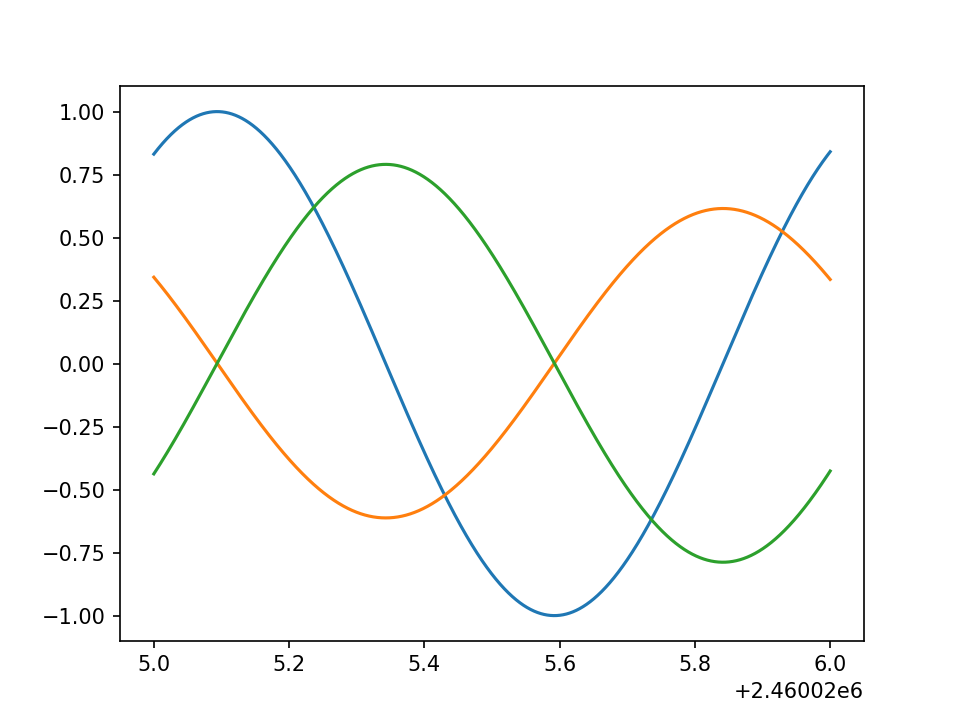

In [23]:
plt.figure()
plt.plot(jds, sun_pos_top[0])
plt.plot(jds, sun_pos_top[1])
plt.plot(jds, sun_pos_top[2])

In [27]:
baseline = np.array([20., 2., 0])  # m

In [28]:
b_proj = np.dot(baseline, sun_pos_top)
lam = C / FREQ
w = b_proj / lam
fringe = np.exp(-2*np.pi*1j*w)
fringe = np.where(sun_pos_top[2] > 0, fringe, 0)

<IPython.core.display.Javascript object>


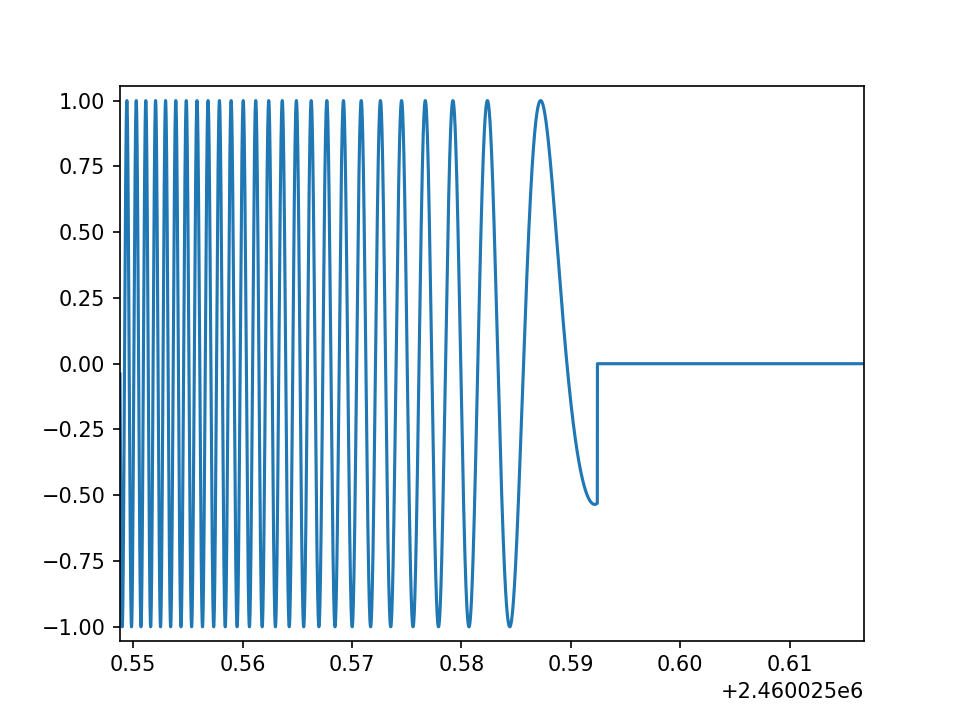

In [29]:
plt.figure()
plt.plot(jds, fringe)

In [42]:
data_files = sorted(glob.glob('sun_data/*.npy'))
print(data_files)

['sun_data/sun_0.npy', 'sun_data/sun_1.npy', 'sun_data/sun_10.npy', 'sun_data/sun_100.npy', 'sun_data/sun_1000.npy', 'sun_data/sun_10000.npy', 'sun_data/sun_10001.npy', 'sun_data/sun_10002.npy', 'sun_data/sun_10003.npy', 'sun_data/sun_10004.npy', 'sun_data/sun_10005.npy', 'sun_data/sun_10006.npy', 'sun_data/sun_10007.npy', 'sun_data/sun_10008.npy', 'sun_data/sun_10009.npy', 'sun_data/sun_1001.npy', 'sun_data/sun_10010.npy', 'sun_data/sun_10011.npy', 'sun_data/sun_10012.npy', 'sun_data/sun_10013.npy', 'sun_data/sun_10014.npy', 'sun_data/sun_10015.npy', 'sun_data/sun_10016.npy', 'sun_data/sun_10017.npy', 'sun_data/sun_10018.npy', 'sun_data/sun_10019.npy', 'sun_data/sun_1002.npy', 'sun_data/sun_10020.npy', 'sun_data/sun_10021.npy', 'sun_data/sun_10022.npy', 'sun_data/sun_10023.npy', 'sun_data/sun_10024.npy', 'sun_data/sun_10025.npy', 'sun_data/sun_10026.npy', 'sun_data/sun_10027.npy', 'sun_data/sun_10028.npy', 'sun_data/sun_10029.npy', 'sun_data/sun_1003.npy', 'sun_data/sun_10030.npy', 's

In [57]:
raw_data = [np.load(f'sun_data/sun_{i}.npy', allow_pickle=True).tolist() for i in range(21000)]

In [100]:
vis = np.array([d['corr01'] for d in raw_data])[:, 400:900]
times = np.array([d['time'] for d in raw_data])
acc_cnt = np.array([d['acc_cnt'] for d in raw_data])
LO = 8.75e9 + 1.54e9
freqs = np.linspace(0, 250e6, 1024, endpoint=False) + LO
freqs = freqs[400:900]

In [69]:
np.diff(acc_cnt)[np.where(np.diff(acc_cnt) != 1)]

array([ 7,  2, 13,  2,  3,  2,  6,  2,  7,  4,  2,  4,  2,  2,  2])

In [75]:
vis -= np.mean(vis, axis=0, keepdims=True)

<IPython.core.display.Javascript object>


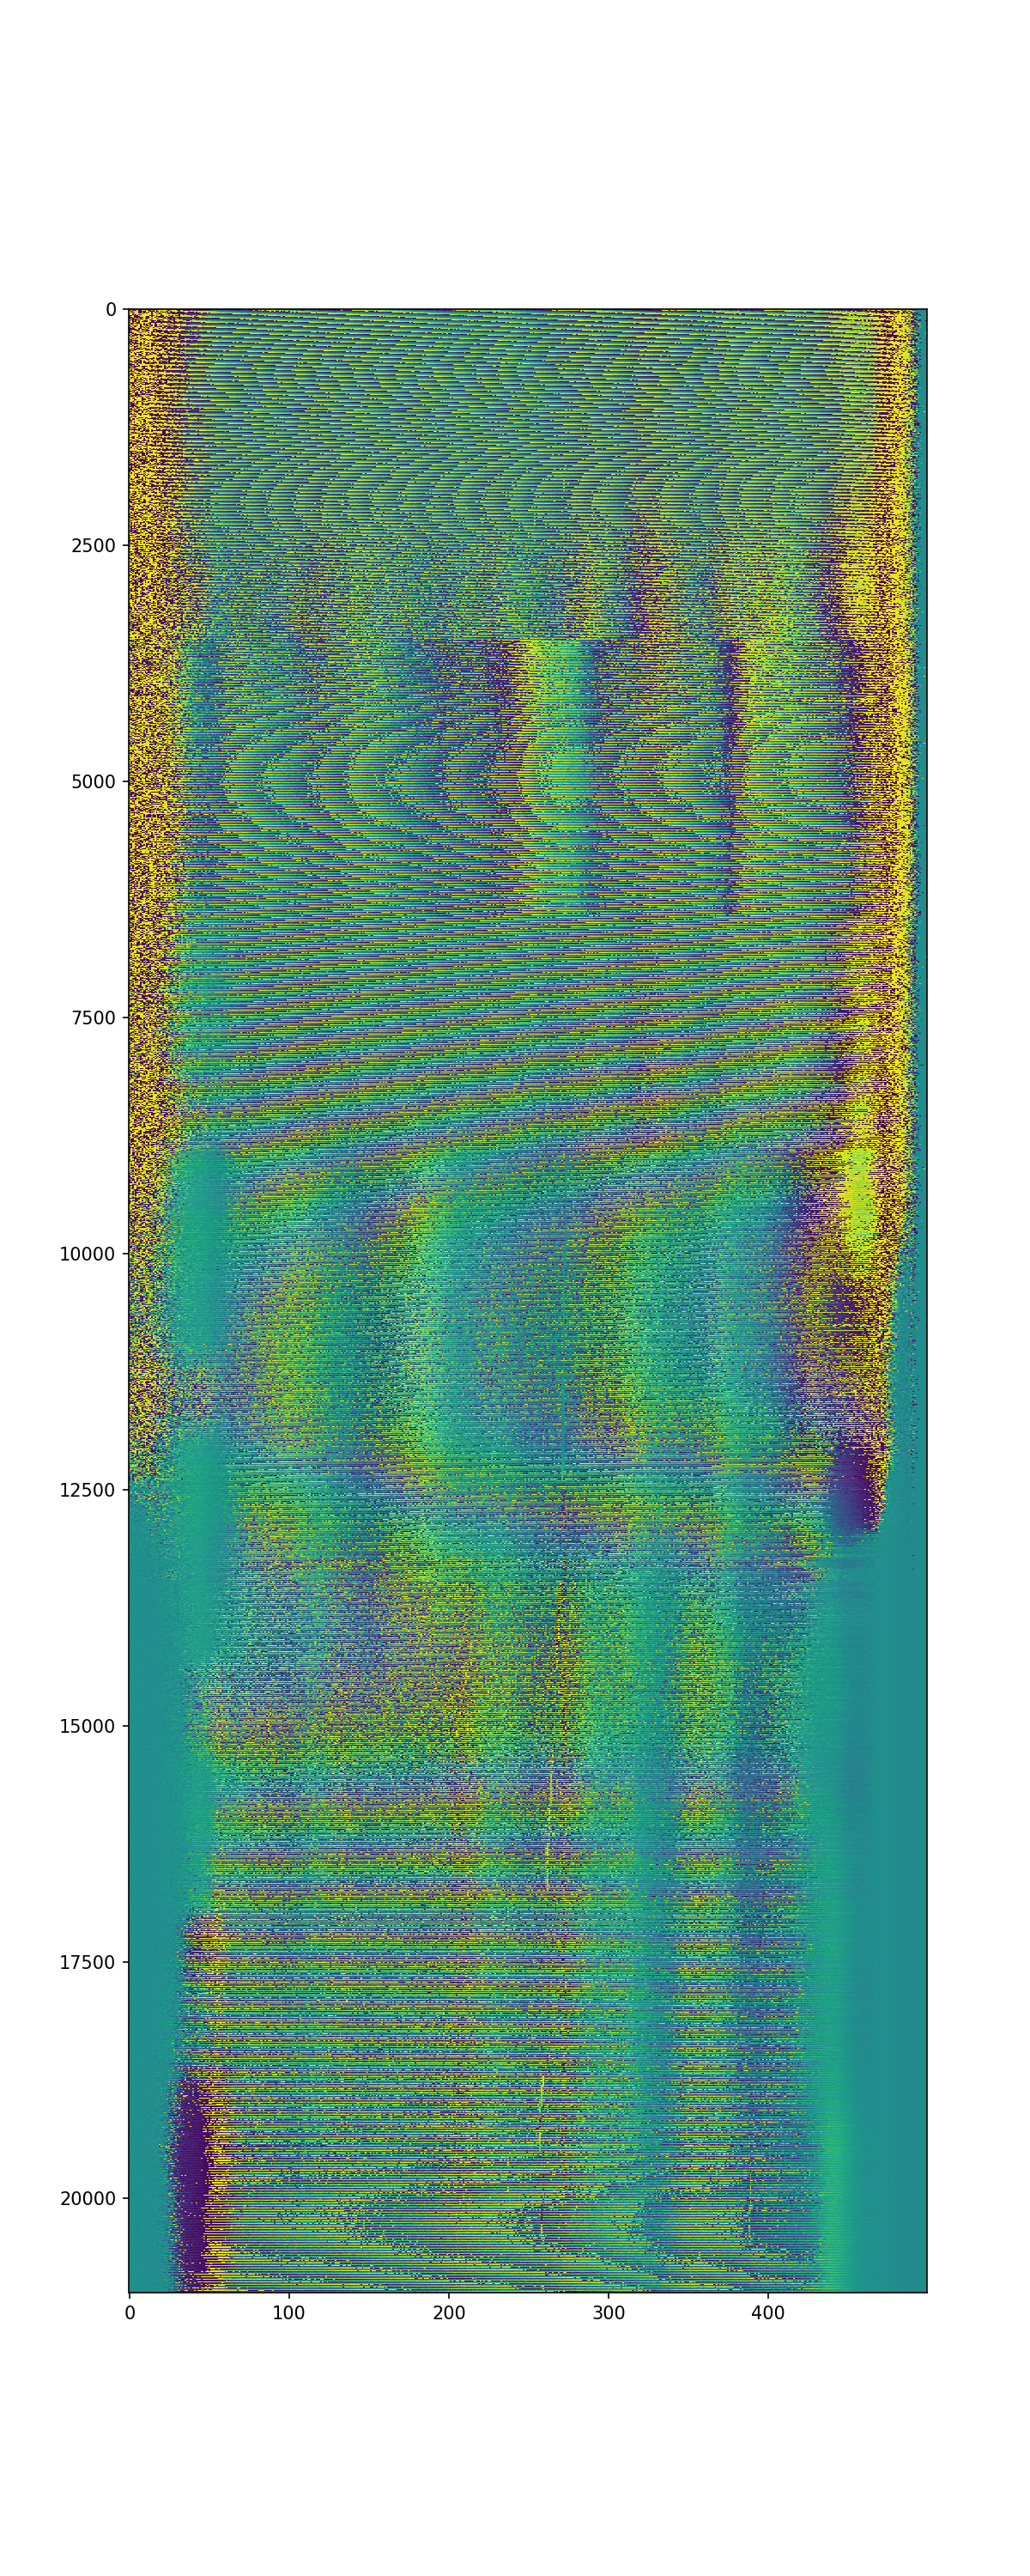

In [77]:
plt.figure(figsize=(8,20))
plt.imshow(np.angle(vis), interpolation='nearest', aspect='auto')

<IPython.core.display.Javascript object>


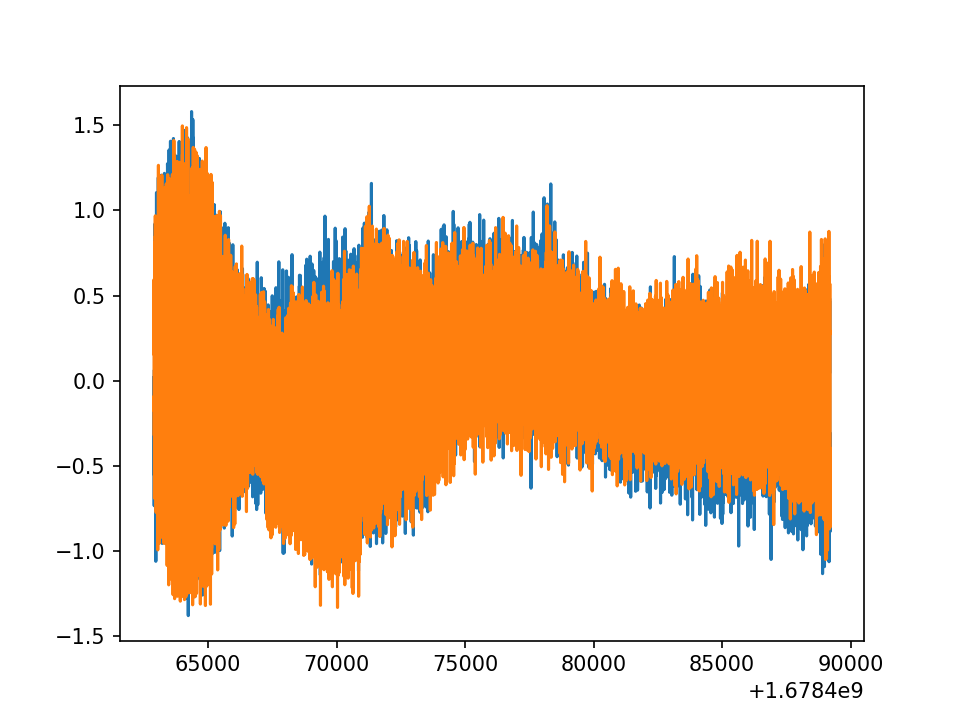

In [79]:
plt.figure()
plt.plot(times, vis[:,200].real)
plt.plot(times, vis[:,200].imag)

In [101]:
v = vis[:,200]
fq = freqs[200]
v.shape

(21000,)

In [85]:
v.shape = (-1, 100)
fringe_fq = np.fft.fft(v, axis=1)

<IPython.core.display.Javascript object>


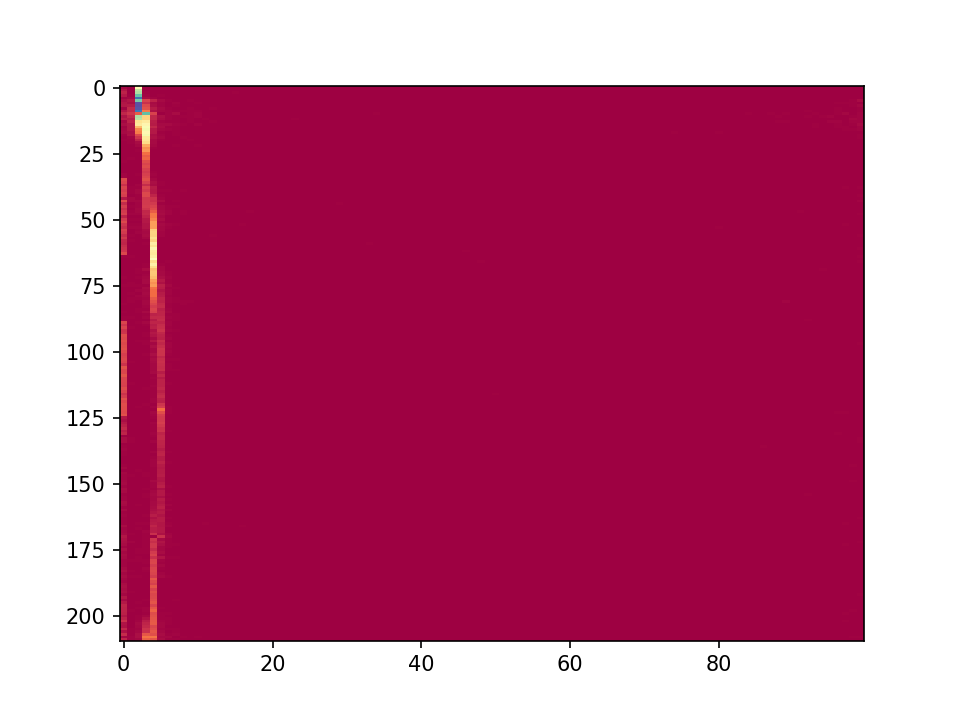

In [87]:
plt.figure()
plt.imshow(np.abs(fringe_fq)**2, interpolation='nearest', aspect='auto', cmap='Spectral')

In [91]:
C * (freqs[1] - freqs[0]) / freqs[0]

7094.076469873664

In [106]:
print(times.shape)
jds_data = ugradio.timing.julian_date(times)
lst0 = ugradio.timing.lst(jds_data[0])
lst1 = ugradio.timing.lst(jds_data[1])
lsts = lst0 + np.arange(jds_data.shape[0]) * (lst1 - lst0)
ones = np.ones_like(lsts)
#ha = lsts - radec[0]
rot_eq_ha = np.array([[
    [np.cos(lsts),  np.sin(lsts),     0*ones],
    [np.sin(lsts), -np.cos(lsts),     0*ones],
    [      0*ones,        0*ones,     1*ones],
]])
lat = np.deg2rad(ugradio.nch.lat)
rot_ha_altaz = np.array([[
    [-np.sin(lat),  0, np.cos(lat)],
    [           0, -1,           0],
    [ np.cos(lat),  0, np.sin(lat)],
]])

rot_full = np.dot(rot_ha_altaz, rot_eq_ha)
rot_full.shape = (3, 3, -1)

(21000,)
(3, 3, 21000)


In [111]:
sun_radec = ugradio.coord.sunpos(jds_data[0])
radec = (np.deg2rad(sun_radec[0]), np.deg2rad(sun_radec[1]))
theta = np.pi/2 - radec[1]
phi = radec[0]
sun_z = np.cos(theta)
r_xy = np.sin(theta)
sun_x = r_xy * np.cos(phi)
sun_y = r_xy * np.sin(phi)
sun_pos_eq = np.array([sun_x, sun_y, sun_z])
sun_pos_top = np.dot(sun_pos_eq, rot_full)
print(sun_pos_top.shape)
sun_pos_top = np.array([sun_pos_top[1], sun_pos_top[0], sun_pos_top[2]])
sun_pos_top.shape

(3, 21000)


(3, 21000)

In [114]:
baseline = np.array([20., 2, 0])
b_proj = np.dot(baseline, sun_pos_top)
lam = C / fq
w = b_proj / lam
fringe = np.exp(-2*np.pi*1j*w)
fringe = np.where(sun_pos_top[2] > 0, fringe, 0)
print(w.shape)

(21000,)


<IPython.core.display.Javascript object>


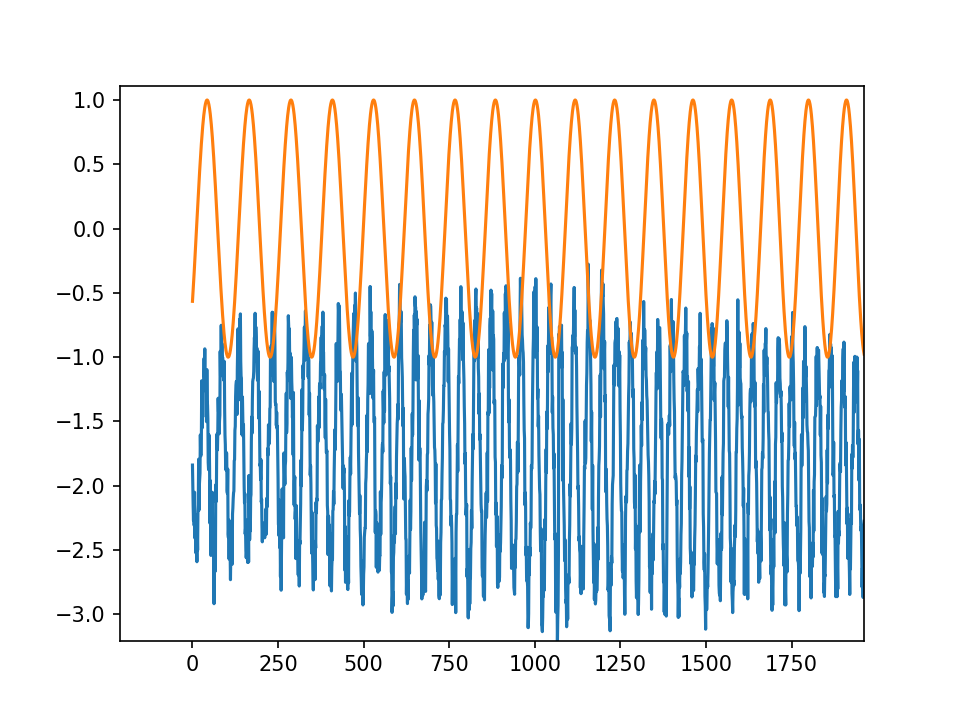

In [117]:
plt.figure()
plt.plot(vis[:, 200].real)
plt.plot(fringe.real)
#plt.plot(jds_data, vis[:, 200].real)
#plt.plot(jds_data, w.real)